In [5]:
import pandas as pd 
import csv
import os 
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
import numpy as np
import matplotlib.pyplot as plt

### Open Data

Open the original EvictionLab block group csv, and keep only data from Virginia, Maryland, and DC

In [6]:
EvictionLab_File = "./data/bg_proprietary_2000_2018_v1.1.csv"
DMV_File = "./data/EvictionLab_bg_DMV.csv"

fips_to_keep = ["11","51","24"]

with open(EvictionLab_File, mode='r') as infile, open(DMV_File, mode='w', newline='') as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile)
    
    # Write the header to the output file
    header = next(reader)
    writer.writerow(header)
    
    # Process each row
    for row in reader:

        block_group_id = row[0].zfill(12)
        
        # Check if the block group ID starts with a valid FIPS code
        if block_group_id[:2] in fips_to_keep:
            writer.writerow(row)

In [7]:
EvictionLab_DMV = pd.read_csv("./data/EvictionLab_bg_DMV.csv")

print(EvictionLab_DMV.shape)

EvictionLab_DMV

(184205, 11)


,id,name,parent_location,year,type,filings,filing_rate,threatened,threatened_rate,judgements,judgement_rate
0,110010001001,"District of Columbia, District of Columbia, 10...",District of Columbia,2000,observed,NaN,NaN,NaN,NaN,NaN,NaN
1,110010001001,"District of Columbia, District of Columbia, 10...",District of Columbia,2001,observed,NaN,NaN,NaN,NaN,NaN,NaN
2,110010001001,"District of Columbia, District of Columbia, 10...",District of Columbia,2002,observed,NaN,NaN,NaN,NaN,NaN,NaN
3,110010001001,"District of Columbia, District of Columbia, 10...",District of Columbia,2003,observed,2.0,0.49,2.0,0.49,1.0,0.25
4,110010001001,"District of Columbia, District of Columbia, 10...",District of Columbia,2004,observed,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
184200,518400003024,"Winchester city, Virginia, 302, 4",Winchester city,2014,observed,5.0,1.50,5.0,1.50,3.0,0.90
184201,518400003024,"Winchester city, Virginia, 302, 4",Winchester city,2015,observed,4.0,1.20,4.0,1.20,3.0,0.90
184202,518400003024,"Winchester city, Virginia, 302, 4",Winchester city,2016,observed,3.0,1.52,3.0,1.52,2.0,1.01
184203,518400003024,"Winchester city, Virginia, 302, 4",Winchester city,2017,observed,7.0,3.54,7.0,3.54,4.0,2.02


In [9]:
EvictionLab_DMV_2018 = EvictionLab_DMV[EvictionLab_DMV["year"] == 2018] # get only 2018 data for target

### Individual Targets

In [20]:
EvictionLab_DMV_2018_Filing = EvictionLab_DMV_2018[~EvictionLab_DMV_2018["filing_rate"].isna() & ~EvictionLab_DMV_2018["filings"].isna()].drop(["threatened","threatened_rate","judgements","judgement_rate"],axis=1)

In [23]:
# drop inf values
EvictionLab_DMV_2018_Filing = EvictionLab_DMV_2018_Filing[~np.isinf(EvictionLab_DMV_2018_Filing["filing_rate"])]
EvictionLab_DMV_2018_Filing = EvictionLab_DMV_2018_Filing[~np.isinf(EvictionLab_DMV_2018_Filing["filings"])]

In [24]:
EvictionLab_DMV_2018_Filing["filings"].describe()

count    6220.000000
mean       54.225563
std       164.971212
min         1.000000
25%         3.000000
50%         8.000000
75%        37.000000
max      3094.000000
Name: filings, dtype: float64

In [ ]:
EvictionLab_DMV_2018_Filing["filing_rate"].describe()

count    6220.000000
mean       19.435238
std        52.465337
min         0.070000
25%         2.970000
50%         6.955000
75%        17.330000
max      2040.000000
Name: filing_rate, dtype: float64

In [ ]:
# save
EvictionLab_DMV_2018_Filing.to_csv("data/EvictionLab_bg_DMV_Filing.csv", index=False)

### Unify Target

Because there are several measures of eviction here, I need a way to turn them into one target. 

#### First, drop NA

In [104]:
EvictionLab_DMV_2018 = EvictionLab_DMV_2018.replace([np.inf, -np.inf], np.nan)

In [105]:
print(EvictionLab_DMV_2018.isna().sum())

id                    0
name                  0
parent_location       0
year                  0
type                  0
filings            3360
filing_rate        3475
threatened         3360
threatened_rate    3475
judgements         3360
judgement_rate     3475
dtype: int64


In [106]:
EvictionLab_DMV_2018 = EvictionLab_DMV_2018.dropna()

In [107]:
len(EvictionLab_DMV_2018)

6220

In [92]:
targets = EvictionLab_DMV_2018[['filings', 'filing_rate', 'threatened', 'threatened_rate', 'judgements', 'judgement_rate']]

<Axes: >

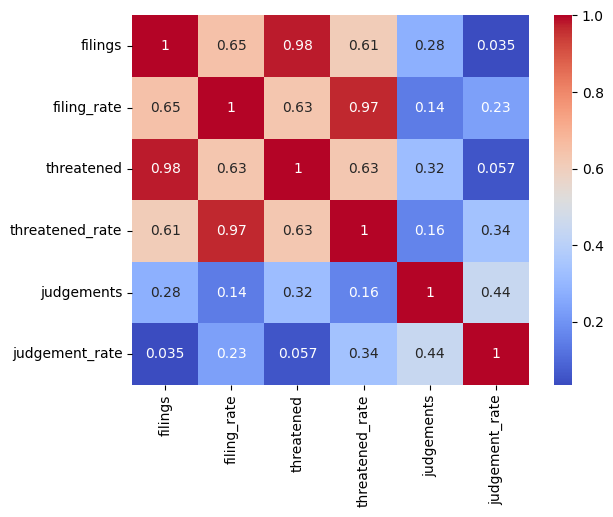

In [60]:
sns.heatmap(targets.corr(),cmap="coolwarm", annot=True) # check for correlation to validate choice of PCA

#### PCA?

In [61]:
# scale the variables for PCA

scaler = StandardScaler()
scaled_data = scaler.fit_transform(targets)

In [63]:
pca = PCA()

pca_data = pca.fit_transform(scaled_data)

In [64]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
explained_variance


array([0.56554681, 0.78256253, 0.93378688, 0.99227636, 0.99883005,
       1.        ])

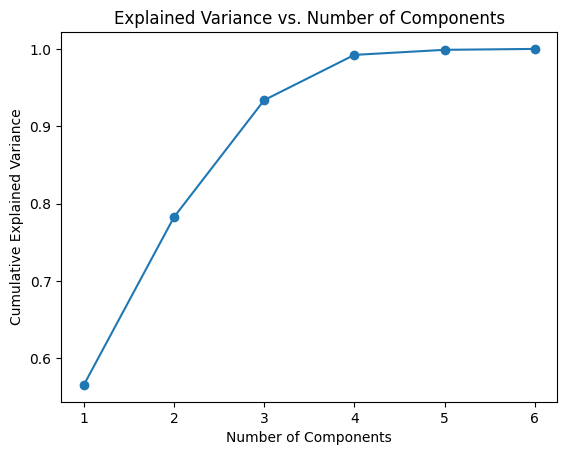

In [66]:
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

In [110]:
eviction_measure = pca_data[:, :4]
EvictionLab_DMV_2018["Eviction_Score"] = np.sum(eviction_measure, axis=1) 


#### Factor Analysis?

In [81]:
n_factors = 2  # You can try different numbers of factors
fa = FactorAnalysis(n_components=n_factors, random_state=42)

# Fit the model and transform the data
fa_data = fa.fit_transform(scaled_data)

In [87]:
targets.columns

Index(['filings', 'filing_rate', 'threatened', 'threatened_rate', 'judgements',
       'judgement_rate', 'Eviction_Score'],
      dtype='object')

In [93]:
loadings_df = pd.DataFrame(fa.components_.T, columns=[f"Factor {i+1}" for i in range(n_factors)], index=targets.columns)
print(loadings_df)

                 Factor 1  Factor 2
filings          0.801753 -0.596922
filing_rate      0.950677  0.194720
threatened       0.810104 -0.550458
threatened_rate  0.962177  0.271557
judgements       0.217631 -0.173897
judgement_rate   0.266646  0.298854


### Save new data

In [111]:
EvictionLab_DMV_2018

,id,name,parent_location,year,type,filings,filing_rate,threatened,threatened_rate,judgements,judgement_rate,Eviction_Score
18,110010001001,"District of Columbia, District of Columbia, 10...",District of Columbia,2018,observed,14.0,4.39,8.0,2.51,0.0,0.00,-1.532614
37,110010001002,"District of Columbia, District of Columbia, 10...",District of Columbia,2018,observed,17.0,4.67,8.0,2.20,0.0,0.00,-1.515131
75,110010001004,"District of Columbia, District of Columbia, 10...",District of Columbia,2018,observed,1.0,0.52,1.0,0.52,0.0,0.00,-1.642614
132,110010002022,"District of Columbia, District of Columbia, 20...",District of Columbia,2018,observed,1.0,1.43,1.0,1.43,0.0,0.00,-1.656247
151,110010002023,"District of Columbia, District of Columbia, 20...",District of Columbia,2018,observed,4.0,2.29,4.0,2.29,0.0,0.00,-1.618109
...,...,...,...,...,...,...,...,...,...,...,...,...
184128,518400003014,"Winchester city, Virginia, 301, 4",Winchester city,2018,observed,17.0,6.23,17.0,6.23,12.0,4.40,-0.184843
184147,518400003021,"Winchester city, Virginia, 302, 1",Winchester city,2018,observed,7.0,1.00,7.0,1.00,6.0,0.86,-1.121692
184166,518400003022,"Winchester city, Virginia, 302, 2",Winchester city,2018,observed,1.0,0.47,1.0,0.47,1.0,0.47,-1.519774
184185,518400003023,"Winchester city, Virginia, 302, 3",Winchester city,2018,observed,4.0,1.65,4.0,1.65,2.0,0.82,-1.383103


In [112]:
EvictionLab_DMV_2018.to_csv("./data/EvictionLab_bg_DMV_processed_target.csv", index=False)